<b>Importing Libraries</b>

In [82]:
import torch
from torch import nn, optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import math
from torch.utils.tensorboard import SummaryWriter

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128

<b> Importing Data </b>

In [22]:
# Custom class to flatten the tensor while loading dataset.
class tensorFlatten():
  def __init__(self, start_dim, end_dim):
    self.start_dim = start_dim
    self.end_dim = end_dim

  def __call__(self, tensor):
    flattened_tensor = torch.flatten(tensor, start_dim=self.start_dim, end_dim=self.end_dim)
    return flattened_tensor

  def __repr__(self):
    repr = f"{self.__class__.__name__  }(start_dim={self.start_dim}, end_dim={self.end_dim})"

In [23]:
# Importing Data
mnist_train = torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                                                transform=torchvision.transforms.Compose([
                                                                                           torchvision.transforms.ToTensor(),
                                                                                           #torchvision.transforms.Normalize((0,),(1,)),
                                                                                           tensorFlatten(0,-1)
                                                                                            ])
                                                )
mnist_test = torchvision.datasets.FashionMNIST('./files/', train=False, download=True,
                                                transform=torchvision.transforms.Compose([
                                                                                           torchvision.transforms.ToTensor(),
                                                                                           #torchvision.transforms.Normalize((0,),(1,)),
                                                                                           tensorFlatten(0,-1)
                                                                                            ])
                                                )


In [24]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, drop_last=True)

<b> Defining Learning Parameters</b>

In [25]:
# Training Parameters
lr = .0002
epochs = 200

# Network parameters
image_dim = 28*28
image_shape = (28,28)
gen_hidden_nodes = 256
dis_hidden_nodes = 256
latent_space_dim = 100

# Defining Generator Network

In [38]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    def block(in_feat, out_feat, normalize=False):
      layers = [nn.Linear(in_feat, out_feat)]
      if normalize:
        layers.append(nn.BatchNorm1d(out_feat,.8))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers

    self.model = nn.Sequential(*block(in_feat = latent_space_dim, out_feat = gen_hidden_nodes),
                               *block(in_feat = gen_hidden_nodes, out_feat = gen_hidden_nodes),
                               nn.Linear(in_features=gen_hidden_nodes, out_features=int(np.prod(image_shape)))
                               )
  def forward(self, t):
    t = t.to(device)
    generated_image = torch.sigmoid(self.model(t))
    generated_image = generated_image.view(generated_image.size(0), *image_shape)
    return generated_image


# Defining Discriminator Network

In [39]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(nn.Linear(int(np.prod(image_shape)), dis_hidden_nodes),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(dis_hidden_nodes, int(dis_hidden_nodes/2)),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(int(dis_hidden_nodes/2),1),
                               )
  def forward(self, t):
    t = t.to(device)
    t = t.view(t.size(0), -1)
    t = self.model(t)
    return torch.sigmoid(t) # BCELoss does not compute sigmoid by default.

# Defining Loss Functions

In [40]:
def GeneratorLoss(fake_output_disc):
  return -torch.mean(torch.log(fake_output_disc) + .0001) # Due to maxlog(D(G(x))
                                                          # - sign is used to maximize the above function.


DiscriminatorLoss = torch.nn.BCELoss() # Does not compute sogmoids by default.

In [41]:
writer_real = SummaryWriter('./logs')
writer_fake = SummaryWriter('./logs')
loss_summary = SummaryWriter('./logs')

# Training Discriminator and Generator

In [98]:
def TrainingLoop(Generator, Discriminator, optimizer_gen, optimizer_dis, epochs, train_loader):
  gen_loss_summary = []
  dis_loss_summary = []

  for epoch in range(epochs):
    print(f'Epoch: {epoch} started---------------------------------------->')
    gen_loss_avg = 0
    dis_loss_avg = 0
    for batch_idx, (real_images,_) in enumerate(train_loader):

      real_images.to(device)

      # Adversarial Ground Truths
      real_labels = torch.ones(size = (batch_size,1)).to(device)
      fake_labels = torch.zeros(size = (batch_size,1)).to(device)

      # Gererate Fake samples
      latent_space = torch.randn((batch_size,latent_space_dim)).to(device)
      fake_images = generator(latent_space).view(-1,int(np.prod(image_shape)))
      #print(type(fake_images))
      #print(fake_images.grad_fn)

      # ---------------------
      #  Train Discriminator
      # ---------------------

      real_loss = DiscriminatorLoss(discriminator(real_images), real_labels)
      fake_loss = DiscriminatorLoss(discriminator(fake_images.detach()), fake_labels)
      dis_loss = real_loss + fake_loss

      optimizer_dis.zero_grad()
      dis_loss.backward()
      #print(generator.parameters())
      optimizer_dis.step()
      #print(fake_images.requires_grad)

      # -----------------
      #  Train Generator
      # -----------------
  
      gen_loss = GeneratorLoss(discriminator(fake_images))
      # Computational graph will be created for discriminator and gradients will be calculated of loss wrt discrimintor weights. 
      # However, this time this is exactly what we need.
      optimizer_gen.zero_grad()
      gen_loss.backward()
      optimizer_gen.step()
   
     

      gen_loss_avg = gen_loss_avg + (gen_loss.item() - gen_loss_avg)/(epoch+1)
      dis_loss_avg = dis_loss_avg + (dis_loss.item() - dis_loss_avg)/(epoch+1)

      

      if(batch_idx%100==0):
        print(f'Epoch: [{epoch}/{epochs}], Batch:{batch_idx}/{len(train_loader)}---->GeneratorLoss = {gen_loss:.4f} and DiscriminatorLoss = {dis_loss:.4f}')
    
    if epoch%10==0:
      with torch.no_grad():
        fake_images = generator(latent_space)
        #img_grid_real = torchvision.utils.make_grid(real_images[:32].reshape(-1,28,28), normalize=True)
        #img_grid_fake = torchvision.utils.make_grid(fake_images[:32].reshape(-1,28,28), normalize=True)
        #print(img_grid_real.shape)
        writer_real.add_images('Mnist Real Images', real_images[:32].reshape(-1,1,28,28))
        writer_fake.add_images("Mnist Fake Images", fake_images[:32].reshape(-1,1,28,28))
        loss_summary.add_scalar('Avg Generator Loss in one Epoch', gen_loss_avg, epoch)
        loss_summary.add_scalar('Avg Discriminator Loss in one Epoch', dis_loss_avg, epoch)

    gen_loss_summary.append(gen_loss_avg)
    dis_loss_summary.append(dis_loss_avg)
  
  print('Finished Training')
  return gen_loss_summary, dis_loss_summary



In [99]:
generator = Generator().to(device)
optimizer_gen = optim.Adam(generator.parameters(), lr = lr)

discriminator = Discriminator().to(device)
optimizer_dis = optim.Adam(discriminator.parameters(), lr=lr)

In [ ]:
generator_loss_summary, test_loss_summary = TrainingLoop(generator, discriminator, optimizer_gen, optimizer_dis, epochs, train_loader)

# Plotting Graphs

[]

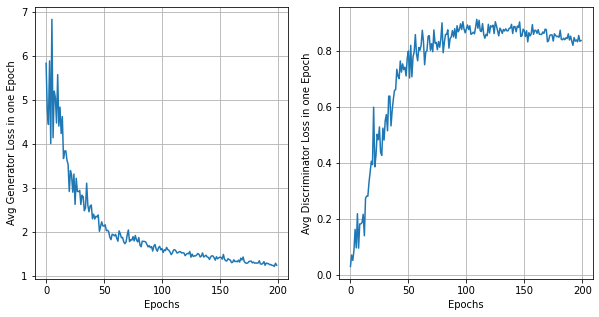

In [107]:
plt.figure(1,figsize=(10,5))
plt.subplot(121)
plt.plot(np.arange(epochs), generator_loss_summary)
plt.xlabel('Epochs')
plt.ylabel('Avg Generator Loss in one Epoch')
plt.grid()

plt.subplot(122)
plt.plot( np.arange(epochs), test_loss_summary)
plt.xlabel('Epochs')
plt.ylabel('Avg Discriminator Loss in one Epoch')
plt.grid()
plt.plot()